In [1]:
import sys
!{sys.executable} -m pip install sklearn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Load data from .txt files and make the train-test splits.
# Since we're working with text data, we need to vectorize the documents / turn each document
# into a point vector in a n-dimentions space. 
# Moreover, rather than simply using the word counts, we want to use the Term Frequency as feature value.

# dataset = load_files('./cleaned_op_spam', encoding='latin-1')
dataset = load_files('./genuine_vs_fake', encoding='utf-8')
x_train, x_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.2)

custom_stop_words = text.ENGLISH_STOP_WORDS.union(["\n"])
vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df=5)
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)
x_train_vec
# print(x_trainvec.toarray())
print(vectorizer.get_feature_names_out())

print('===== Target classes =====')
print(dataset.target_names)
# print(dataset)

['00' '10' '100' ... 'yelling' 'yes' 'young']
===== Target classes =====
['fake', 'genuine']


In [4]:
dataset

{'data': ["The Omni Chicago Hotel I am a business woman who travels a great deal out of a month, therefore, my accommodations must meet the highest standards. I was booked for a stay at The Omni Chicago Hotel, located in what is referred to as ' The Magnificent Mile ' in the greater Chicago area. ' Magnificent ', it was! The beautifully red-bricked sky scraper was indeed a breath- taking sight and upon entrance, I had a felling of warmth from the very hospitable welcoming staff. I was impressed with the hotels special rates offered during prime business hours and the guest rooms ranged everything from ' The Presidential Suite to The Governors Suite '. I accepted a more humble room as I would not need to spend very much time there during the day. I did stay inside most nights and the amenities were more than satisfactory. I enjoyed the very spacious exercise room and afterwards, I would take a quick dip in the pool. I toured the hotel as my niece is planning her wedding and just so happ

In [5]:
# word frequency for ALL corpuses
import pandas as pd
c_vectorizer = CountVectorizer(stop_words=custom_stop_words)
all_words = c_vectorizer.fit_transform(dataset.data)
counts = pd.DataFrame(all_words.toarray(), columns=c_vectorizer.get_feature_names_out())
sorted_counts = counts.sum().sort_values(ascending=False)
print(sorted_counts)

hotel         1657
room          1292
stay           658
service        408
staff          408
              ... 
louisville       1
lounges          1
bisquit          1
lover            1
nook             1
Length: 6770, dtype: int64


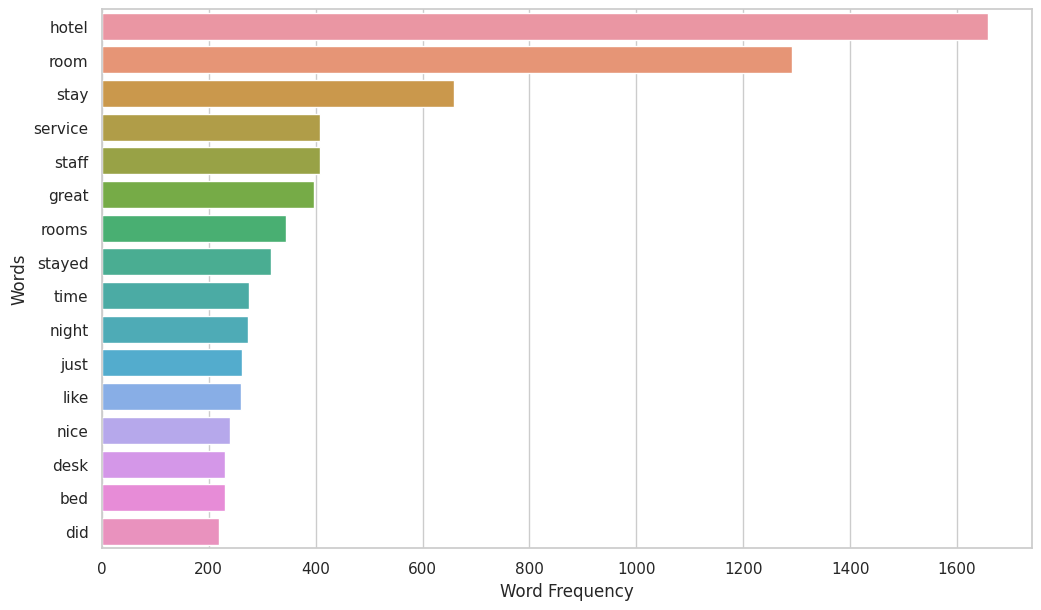

In [6]:
import seaborn as sns
limit = 16
custom_params = {'figure.figsize':(12,7)}
sns.set_theme(style="whitegrid", rc=custom_params)
ax = sns.barplot(y=sorted_counts.index[:limit], x=sorted_counts.values[:limit])
ax.set(xlabel='Word Frequency', ylabel='Words')
plt.show()

In [7]:
# Fit and test the models
mnb = MultinomialNB()
preds_mnb = mnb.fit(x_train_vec, y_train).predict(x_test_vec)
print("MNB correct predictions %d out of %d" % ((y_test == preds_mnb).sum(), x_test_vec.shape[0]))

loreg1 = LogisticRegression(solver='lbfgs')
preds_logreg1 = loreg1.fit(x_train_vec, y_train).predict(x_test_vec)
print("LReg-LBFGS correct predictions %d out of %d" % ((y_test == preds_logreg1).sum(), x_test_vec.shape[0]))

logreg2 = LogisticRegression(solver='liblinear')
preds_logreg2 = logreg2.fit(x_train_vec, y_train).predict(x_test_vec)
print(f"LReg-Liblinear correct predictions {(y_test == preds_logreg2).sum()} out of {x_test_vec.shape[0]}")

logreg3 = LogisticRegression(solver='saga')
preds_logreg3 = logreg3.fit(x_train_vec, y_train).predict(x_test_vec)
print(f"LReg-Saga correct predictions {(y_test == preds_logreg3).sum()} out of {x_test_vec.shape[0]}")

dectree = DecisionTreeClassifier()
preds_dectree = dectree.fit(x_train_vec, y_train).predict(x_test_vec)
print(f"Decision Tree correct predictions {(y_test == preds_dectree).sum()} out of {x_test_vec.shape[0]}")

rforest = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
preds_rforest = rforest.fit(x_train_vec, y_train).predict(x_test_vec)
print(f"Random Forest correct predictions {(y_test == preds_rforest).sum()} out of {len(y_test)}")

MNB correct predictions 155 out of 160
LReg-LBFGS correct predictions 153 out of 160
LReg-Liblinear correct predictions 154 out of 160
LReg-Saga correct predictions 153 out of 160
Decision Tree correct predictions 125 out of 160
Random Forest correct predictions 134 out of 160


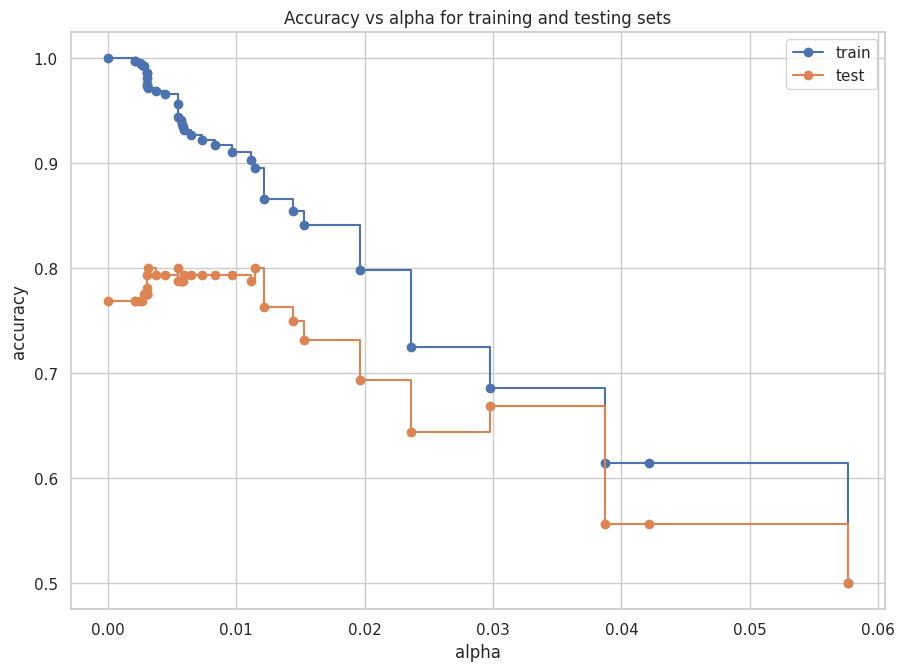

In [8]:
# Attempt to optimize the Decision Tree using Cost-Complexity Pruning technique
path = dectree.cost_complexity_pruning_path(x_train_vec, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
# print(ccp_alphas)
# print(impurities)

dtrees = []
for ccp_alpha in ccp_alphas:
    dtr = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    dtr.fit(x_train_vec, y_train)
    dtrees.append(dtr)
# print(f"Number of nodes in the last tree is: {dectrees[-1].tree_.node_count} with ccp_alpha: {ccp_alphas[-1]}")

train_scores = [dtr.score(x_train_vec, y_train) for dtr in dtrees]
test_scores = [dtr.score(x_test_vec, y_test) for dtr in dtrees]

fig, ax = plt.subplots()
fig.set_size_inches(10.5, 7.5)
fig.set_dpi(100)
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

# CONCLUSION: Accuracy optimizes at alpha 0.01. However, the score remains at ±52% so there is no noticeable 
# improvement achieved by the cost-complexity pruning, compared to the simple un-pruned tree.

In [9]:
# fake vs genuine - all probabilities are sorted
mnb_prob = mnb.feature_log_prob_[:,:]
# print(mnb_prob, mnb_prob.argsort()[::-1])

loreg_coef = loreg1.coef_
#print(loreg_coef, loreg_coef.argsort()[::-1])

# np.set_printoptions(threshold=sys.maxsize)
print("All Feature Words:\n", vectorizer.get_feature_names_out())
range = 25

# fake_mnb = mnb_prob[0, :].argsort()[::-1]
# print("\nImportant Words - Fake MNB:\n", np.take(vectorizer.get_feature_names_out(), fake_mnb[:range]))
loreg = loreg_coef[0, :].argsort()[::-1]
print("\nImportant Words - Logistic Regression:\n", np.take(vectorizer.get_feature_names_out(), loreg[:range]))

# true_mnb = mnb_prob[1, :].argsort()[::-1]
# true_loreg = loreg_coef[1, :].argsort()[::-1]
# print("\nImportant Words - True MNB:\n", np.take(vectorizer.get_feature_names_out(), true_mnb[:range]))
# print("\nImportant Words - True LoReg:\n", np.take(vectorizer.get_feature_names_out(), true_loreg[:range]))

All Feature Words:
 ['00' '10' '100' ... 'yelling' 'yes' 'young']

Important Words - Logistic Regression:
 ['small' 'told' 'room' 'floor' 'called' 'did' 'bathroom' 'desk' 'rude'
 'night' 'construction' 'phone' 'old' 'booked' 'wasn' 'manager' 'said'
 'dirty' 'reservation' 'better' 'open' 'bed' 'elevators' 'charge'
 'elevator']


Sorted Forest [322 857 225 ... 781 780 669]
['definitely' 'perfect' 'clean' ... 'nearly' 'nearby' 'literally']


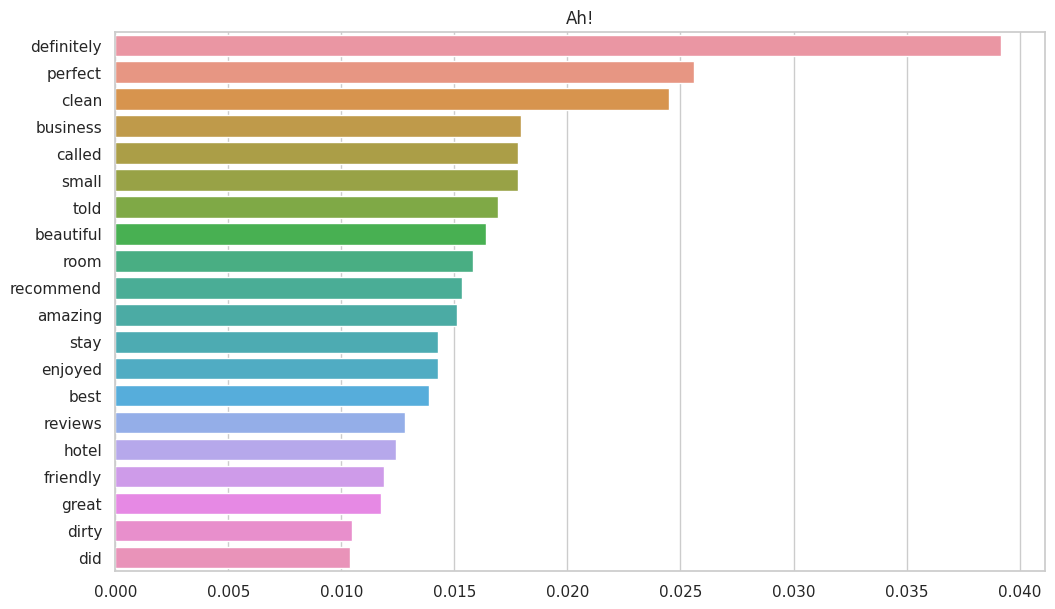

In [10]:
sorted_idx = rforest.feature_importances_.argsort()[::-1]
f_words = np.take(vectorizer.get_feature_names_out(), sorted_idx)
print("Sorted Forest", sorted_idx)
print(f_words)
ax = sns.barplot(y=f_words[:20], x=rforest.feature_importances_[sorted_idx][:20])
ax.set_title("Ah!")
plt.show()

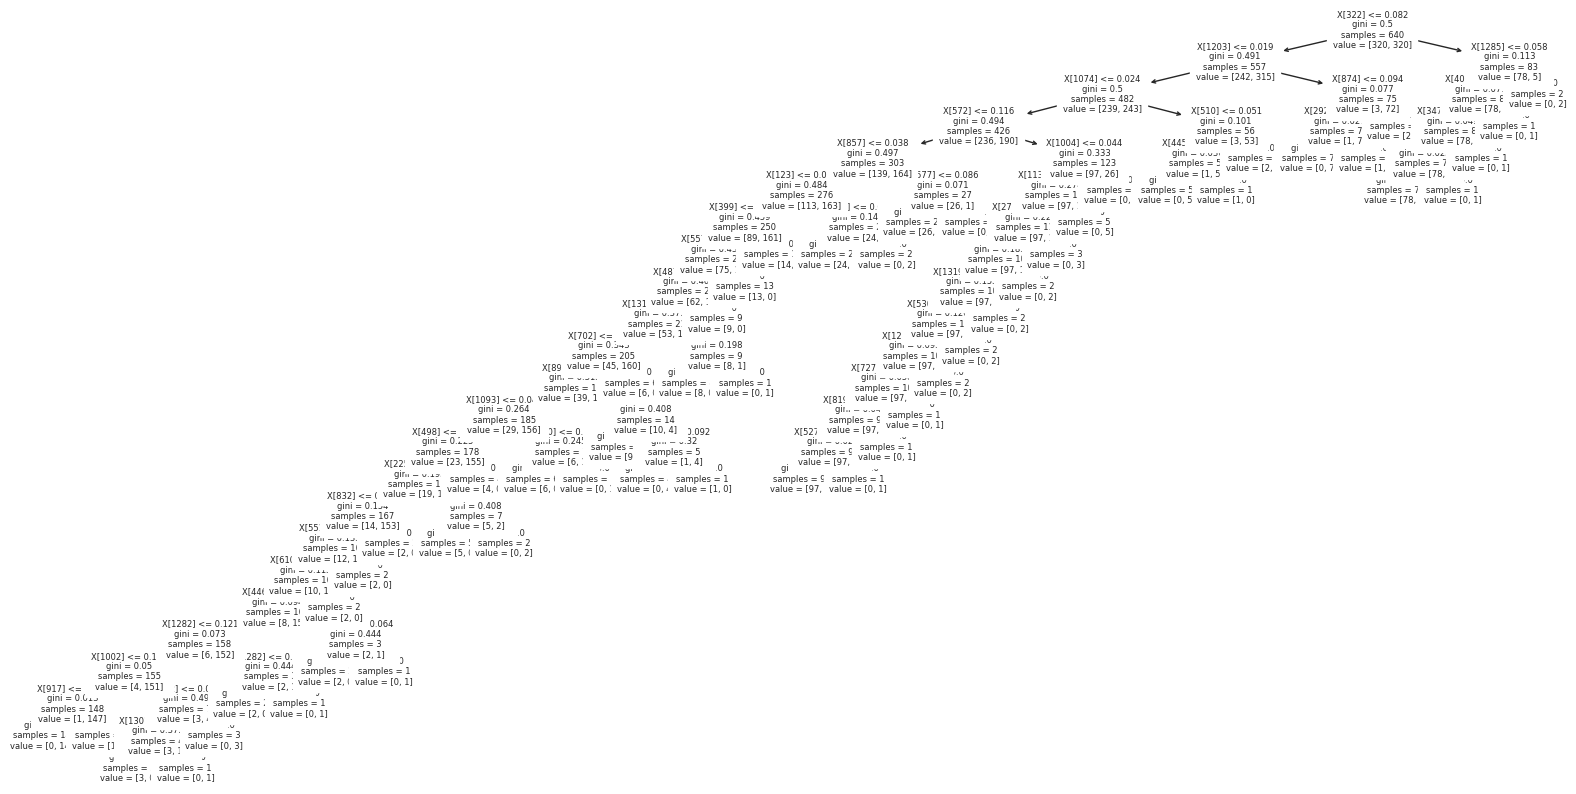

In [20]:
from sklearn import tree
# plot tree
plt.figure(figsize=(30,16))  # set plot size (denoted in inches)
tree.plot_tree(dectree, fontsize=6)
plt.show()

In [12]:
def run_cross_validation(nfolds, ngram=1):
    tf_vectorizer = TfidfVectorizer(stop_words=custom_stop_words, ngram_range=(ngram, ngram))
    x_train_vec = tf_vectorizer.fit_transform(dataset.data)
    y_train_vec = dataset.target

    mnbayes = MultinomialNB()
    logreg = LogisticRegression(solver='lbfgs')
    logreg2 = LogisticRegression(solver='liblinear')
    logreg3 = LogisticRegression(solver='saga')
    dtree = DecisionTreeClassifier()
    ranForest = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
    
    # Naive Bayes
    bayes_acc = cross_val_score(mnbayes, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy', n_jobs=-1).mean()
    bayes_prec = 0 #cross_val_score(mnbayes, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    bayes_rec = 0 #cross_val_score(mnbayes, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    #Logistic regression
    lg_acc = cross_val_score(logreg, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy', n_jobs=-1).mean()
    lg_prec = 0 #cross_val_score(logreg, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    lg_rec = 0 #cross_val_score(logreg, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    lg2_acc = cross_val_score(logreg2, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy', n_jobs=-1).mean()
    lg2_prec = 0 #cross_val_score(logreg2, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    lg2_rec = 0 #cross_val_score(logreg2, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    lg3_acc = cross_val_score(logreg3, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy', n_jobs=-1).mean()
    lg3_prec = 0 #cross_val_score(logreg3, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    lg3_rec = 0 #cross_val_score(logreg3, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
            
    dt_acc = cross_val_score(dtree, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy', n_jobs=-1).mean()
    dt_prec = 0 #cross_val_score(dtree, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    dt_rec = 0 #cross_val_score(dtree, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    ranForest_acc = cross_val_score(ranForest, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy', n_jobs=-1).mean()
    ranForest_prec = 0 #cross_val_score(ranForest, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    ranForest_rec = 0 #cross_val_score(ranForest, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    print(f'         Model                         | Accuracy | Precision | Recall')
    print(f'Naive Bayes                            | {round(bayes_acc, 3)}    | {round(bayes_prec, 3)}    | {round(bayes_rec, 3)}')
    print(f'Logistic Regression - LBFGS solver     | {round(lg_acc, 3)}    | {round(lg_prec, 3)}    | {round(lg_rec, 3)}')
    print(f'Logistic Regression - Liblinear solver | {round(lg2_acc, 3)}    | {round(lg2_prec, 3)}    | {round(lg2_rec, 3)}')
    print(f'Logistic Regression - Saga solver      | {round(lg3_acc, 3)}    | {round(lg3_prec, 3)}    | {round(lg3_rec, 3)}')
    print(f'Decision Tree                          | {round(dt_acc, 3)}    | {round(dt_prec, 3)}    | {round(dt_rec, 3)}')
    print(f'Random Forest                          | {round(ranForest_acc, 3)}    | {round(ranForest_prec, 3)}    | {round(ranForest_rec, 3)}')

In [13]:
print('===== UNIGRAM, 5 folds cv =====')
run_cross_validation(nfolds=5, ngram=1)
print('===== UNIGRAM, 10 folds cv =====')
run_cross_validation(nfolds=10, ngram=1)
print('\n===== BIGRAM, 5 folds cv =====')
run_cross_validation(nfolds=5, ngram=2)
print('\n===== BIGRAM, 10 folds cv =====')
run_cross_validation(nfolds=10, ngram=2)

===== UNIGRAM, 5 folds cv =====


/home/sushii/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


         Model                         | Accuracy | Precision | Recall
Naive Bayes                            | 0.965    | 0    | 0
Logistic Regression - LBFGS solver     | 0.961    | 0    | 0
Logistic Regression - Liblinear solver | 0.962    | 0    | 0
Logistic Regression - Saga solver      | 0.961    | 0    | 0
Decision Tree                          | 0.811    | 0    | 0
Random Forest                          | 0.886    | 0    | 0
===== UNIGRAM, 10 folds cv =====


/home/sushii/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sushii/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sushii/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


         Model                         | Accuracy | Precision | Recall
Naive Bayes                            | 0.965    | 0    | 0
Logistic Regression - LBFGS solver     | 0.964    | 0    | 0
Logistic Regression - Liblinear solver | 0.964    | 0    | 0
Logistic Regression - Saga solver      | 0.962    | 0    | 0
Decision Tree                          | 0.822    | 0    | 0
Random Forest                          | 0.865    | 0    | 0

===== BIGRAM, 5 folds cv =====
         Model                         | Accuracy | Precision | Recall
Naive Bayes                            | 0.724    | 0    | 0
Logistic Regression - LBFGS solver     | 0.903    | 0    | 0
Logistic Regression - Liblinear solver | 0.904    | 0    | 0
Logistic Regression - Saga solver      | 0.904    | 0    | 0
Decision Tree                          | 0.775    | 0    | 0
Random Forest                          | 0.793    | 0    | 0

===== BIGRAM, 10 folds cv =====
         Model                         | Accuracy | Precision